In [1]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geojson
import openslide
import cv2
import logging
from typing import List, Tuple, Optional
import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='pandas')
warnings.filterwarnings('ignore')

# Local module imports
sys.path.append(os.path.abspath('..'))
from utils.image_utils import plot_artery_ann
from utils.geometry_annotation_utils import (clean_geojson_annotations, 
                                             get_outer_cnt)
from utils.utils_measure import measure_thickness

from utils.utils_stat_process import post_process
from utils.utils_stat_feature import extract_features
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# Constants for file paths
VESSEL_PAT_INFO_PATH = "/DataMount/NEPTUNE/Vessel_Project/vessel_pat_info_20240303.csv"
VESSEL_CLASSIFICATION_PATH = "/workspace/vessel_ai/artery_classification/Neptune_Artery_Classification_Sheets.xlsx"
VESSEL_SEGMENTATION_DIR = "/DataMount/NEPTUNE/Vessel_Project/data_selection/ann_geojson/all"
TRI_DIR = "/DataMount/NEPTUNE/Vessel_Project/TRI/"
DIR_SAVE = "/DataMount/NEPTUNE/Vessel_Project/cropped_arteries_by_types_w_ann"
THICKNESS_SAVE_PATH = os.path.join("/DataMount/NEPTUNE/Vessel_Project", "thickness_0501.json")
THICKNESS_CONVEX_SAVE_PATH = os.path.join("/DataMount/NEPTUNE/Vessel_Project", "thickness_convex_0501.json")

ARTERY_TYPES = ["Arterioles", "Interlobular Arteries", "Arcuate Arteries"]
# Mapping dictionary for severity
SEVERITY_MAPPING = {
    '0 - No': 0,
    '1 - Mild': 1,
    '2 - Moderate': 2,
    '3 - Severe': 3
}

In [3]:
pat_df = pd.read_csv(VESSEL_PAT_INFO_PATH)

pat_df = pat_df[pat_df["WSI_Selected"].notna() 
                & pat_df["ESRDorEGFR40BX_LR"].notna() 
                & pat_df["DaysBXtoESRDorEGFR40_LR"].notna()]

In [4]:
df_thickness_features = pd.read_csv("features_label_15_30_10_10_0527.csv")
df_thickness_features.loc[:, "WSI_Fake_Name"] = df_thickness_features.loc[:, "Image Name"].str[:18]

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  2.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  2.,  1.,  1.,
         0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  0.,  2.,  0.,  0.,  3.,  0.,  1.,  0.,  1.,  0.,  2.,
         0.,  1.,  0.,  2.,  1.,  1.,  0.,  1.,  2.,  0.,  1.,  0.,  3.,
         0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  1.,  1.,  0.,  4.,  4.,
         2.,  2.,  1.,  2.,  2.,  3.,  1.,  2.,  1.,  2.,  2.,  2.,  0.,
         1.,  2.,  0.,  0.,  1.,  5.,  4.,  3.,  5.,  9.,  4.,  3.,  4.,
         5.,  5.,  7.,  4.,  5.,  8.,  7.,  5.,  5.,  7.,  5.,  8.,  8.,
         6.,  7.,  6., 10.,  6.,  6.,  9.,  9.,  9.,  6.,  7.,  8.,  2.,
         9.,  6.,  3.,  7.,  6.,  9.,  4.,  7.,  4.,  8., 16.,  5.,  3.,
        12., 10., 11.,  8.,  5.,  9.,  6.,  7.,  8.

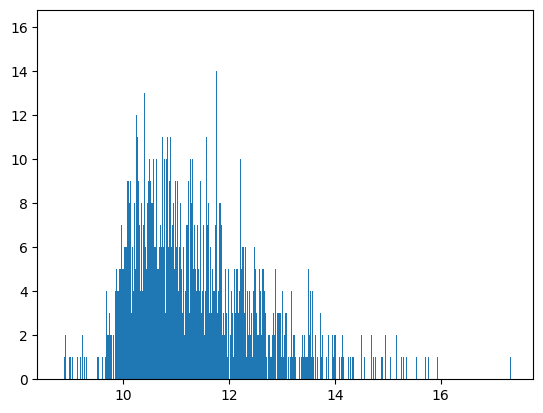

In [11]:
artery_area_arr = df_thickness_features.loc[:, "Artery Area"].values
plt.hist(np.log(artery_area_arr), bins=1000)

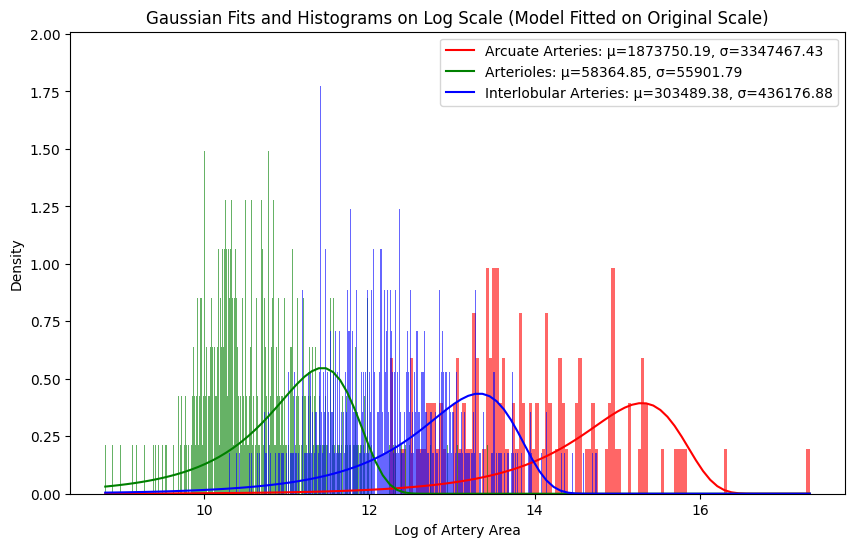

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from scipy.stats import norm

# Assuming df_thickness_features is already loaded and contains the relevant data
df_artery_type_artery_area = df_thickness_features.loc[:, ["Image Name", "Artery Type", "Artery Area"]]

# Remove duplicates based on 'Image Name'
df_artery_type_artery_area_unique = df_artery_type_artery_area.drop_duplicates(subset='Image Name')

# Ensure only the three specific artery types are included
df_artery_type_artery_area_unique = df_artery_type_artery_area_unique[
    df_artery_type_artery_area_unique['Artery Type'].isin(['Arcuate Arteries', 'Interlobular Arteries', 'Arterioles'])
]

# Encode the artery types
le = LabelEncoder()
df_artery_type_artery_area_unique['Artery Type Encoded'] = le.fit_transform(df_artery_type_artery_area_unique['Artery Type'])

# Prepare the data for fitting
X = df_artery_type_artery_area_unique['Artery Area'].values.reshape(-1, 1)
y = df_artery_type_artery_area_unique['Artery Type Encoded']

# Train a Gaussian Naive Bayes model
model = GaussianNB()
model.fit(X, y)

# Prepare to plot in log scale - calculate x values for PDF plotting in log scale

log_x_values = np.linspace(np.log(X.min()), np.log(X.max()), 100)
x_values = np.exp(log_x_values)  # back-transform to original scale for PDF calculation

# Plotting each class's PDF and histogram on a log scale
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'green', 'blue']
labels = le.classes_

for i in range(len(model.classes_)):
    # Use the model's mean and variance for the original scale
    mu, var = model.theta_[i][0], model.var_[i][0]
    pdf = norm.pdf(x_values, mu, np.sqrt(var))
    p_scaled = pdf * x_values  # Scale the PDF by x to adjust for the change of variable (log scale)

    # Plotting histograms of the log-transformed data
    log_group = np.log(X[y == i])
    ax.hist(log_group, bins=len(log_group), density=True, alpha=0.6, color=colors[i])
    # Plotting the scaled PDF
    ax.plot(log_x_values, p_scaled, color=colors[i], label=f'{labels[i]}: μ={mu:.2f}, σ={np.sqrt(var):.2f}')

# Set decision boundaries where the probabilities of two classes are equal
# decision_boundaries = []
# for i in range(len(model.classes_) - 1):
#     boundary = (model.theta_[i][0] + model.theta_[i + 1][0]) / 2
#     decision_boundaries.append(boundary)
#     ax.axvline(np.log(boundary), color='black', linestyle='--')
#     ax.text(np.log(boundary), ax.get_ylim()[1] * 0.5, f'Threshold\n{boundary:.2f}', rotation=90, verticalalignment='center')

ax.legend()
ax.set_title('Gaussian Fits and Histograms on Log Scale (Model Fitted on Original Scale)')
ax.set_xlabel('Log of Artery Area')
ax.set_ylabel('Density')

plt.show()


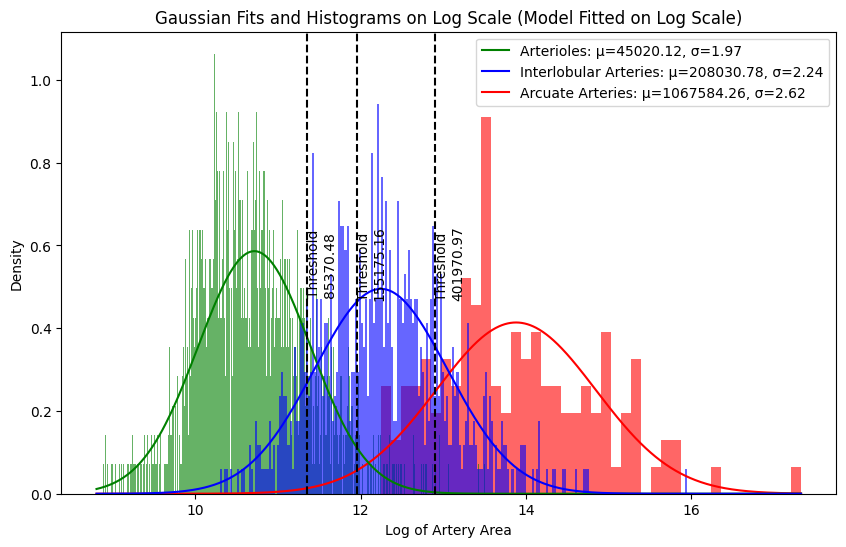

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from scipy.stats import norm

# Assuming df_thickness_features is already loaded and contains the relevant data
df_artery_type_artery_area = df_thickness_features.loc[:, ["Image Name", "Artery Type", "Artery Area"]]

# Remove duplicates based on 'Image Name'
df_artery_type_artery_area_unique = df_artery_type_artery_area.drop_duplicates(subset='Image Name')

# Ensure only the three specific artery types are included
df_artery_type_artery_area_unique = df_artery_type_artery_area_unique[
    df_artery_type_artery_area_unique['Artery Type'].isin(['Arterioles', 'Interlobular Arteries', 'Arcuate Arteries'])
]

# Change the order of artery types for legend and boundaries
order = ['Arterioles', 'Interlobular Arteries', 'Arcuate Arteries']
df_artery_type_artery_area_unique['Artery Type'] = pd.Categorical(
    df_artery_type_artery_area_unique['Artery Type'], 
    categories=order, 
    ordered=True
)

# Encode the artery types
le = LabelEncoder()
df_artery_type_artery_area_unique['Artery Type Encoded'] = le.fit_transform(df_artery_type_artery_area_unique['Artery Type'])

# Prepare the data for fitting
X = df_artery_type_artery_area_unique['Artery Area'].values.reshape(-1, 1)
y = df_artery_type_artery_area_unique['Artery Type Encoded']

# Apply log transformation to the data
log_X = np.log(X)

# Train a Gaussian Naive Bayes model
model = GaussianNB()
model.fit(log_X, y)

# Prepare to plot in log scale - calculate x values for PDF plotting in log scale
log_x_values = np.linspace(log_X.min(), log_X.max(), 1000)
x_values = np.exp(log_x_values)  # back-transform to original scale for PDF calculation

# Plotting each class's PDF and histogram on a log scale
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'green', 'blue']
labels = le.classes_

# Function to find the intersection points of two Gaussian distributions
def find_intersection(mu1, sigma1, mu2, sigma2):
    a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
    b = mu2/(sigma2**2) - mu1/(sigma1**2)
    c = mu1**2/(2*sigma1**2) - mu2**2/(2*sigma2**2) + np.log(sigma2/sigma1)
    return np.roots([a, b, c])

for i in range(len(model.classes_)):
    # Use the model's mean and variance for the original scale
    mu, var = model.theta_[i][0], model.var_[i][0]
    pdf = norm.pdf(log_x_values, mu, np.sqrt(var))
    
    # Plotting histograms of the log-transformed data
    ax.hist(log_X[y == i], bins=len(X[y==i])//3, density=True, alpha=0.6, color=colors[i])
    # Plotting the PDF
    ax.plot(log_x_values, pdf, color=colors[i], label=f'{labels[i]}: μ={np.exp(mu):.2f}, σ={np.exp(np.sqrt(var)):.2f}')

# Calculate and plot decision boundaries
mu1, sigma1 = model.theta_[0][0], np.sqrt(model.var_[0][0])
mu2, sigma2 = model.theta_[1][0], np.sqrt(model.var_[1][0])
mu3, sigma3 = model.theta_[2][0], np.sqrt(model.var_[2][0])

boundaries_1_2 = find_intersection(mu1, sigma1, mu2, sigma2)
boundaries_2_3 = find_intersection(mu2, sigma2, mu3, sigma3)
boundaries_1_3 = find_intersection(mu1, sigma1, mu3, sigma3)

for boundary in boundaries_1_2:
    if log_x_values.min() <= boundary <= log_x_values.max():
        ax.axvline(boundary, color='black', linestyle='--')
        ax.text(boundary, ax.get_ylim()[1] * 0.5, f'Threshold\n{np.exp(boundary):.2f}', rotation=90, verticalalignment='center')

for boundary in boundaries_2_3:
    if log_x_values.min() <= boundary <= log_x_values.max():
        ax.axvline(boundary, color='black', linestyle='--')
        ax.text(boundary, ax.get_ylim()[1] * 0.5, f'Threshold\n{np.exp(boundary):.2f}', rotation=90, verticalalignment='center')

for boundary in boundaries_1_3:
    if log_x_values.min() <= boundary <= log_x_values.max():
        ax.axvline(boundary, color='black', linestyle='--')
        ax.text(boundary, ax.get_ylim()[1] * 0.5, f'Threshold\n{np.exp(boundary):.2f}', rotation=90, verticalalignment='center')

# Update legend to be in the desired order
handles, _ = ax.get_legend_handles_labels()
order_dict = {label: handles[i] for i, label in enumerate(labels)}
ordered_handles = [order_dict[label] for label in order]
ax.legend(handles=ordered_handles)

ax.set_title('Gaussian Fits and Histograms on Log Scale (Model Fitted on Log Scale)')
ax.set_xlabel('Log of Artery Area')
ax.set_ylabel('Density')

plt.show()


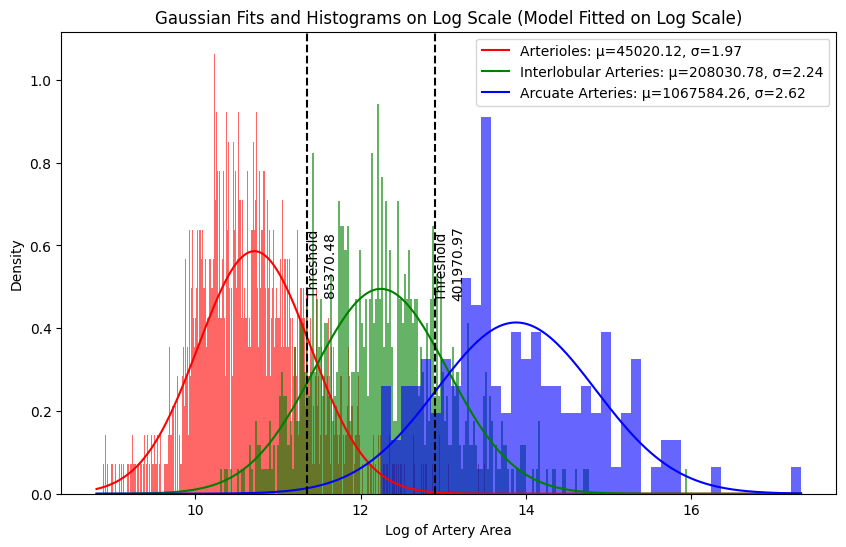

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming df_thickness_features is already loaded and contains the relevant data
df_artery_type_artery_area = df_thickness_features.loc[:, ["Image Name", "Artery Type", "Artery Area"]]

# Remove duplicates based on 'Image Name'
df_artery_type_artery_area_unique = df_artery_type_artery_area.drop_duplicates(subset='Image Name')

# Ensure only the three specific artery types are included
df_artery_type_artery_area_unique = df_artery_type_artery_area_unique[
    df_artery_type_artery_area_unique['Artery Type'].isin(['Arterioles', 'Interlobular Arteries', 'Arcuate Arteries'])
]

# Change the order of artery types for legend and boundaries
order = ['Arterioles', 'Interlobular Arteries', 'Arcuate Arteries']
df_artery_type_artery_area_unique['Artery Type'] = pd.Categorical(
    df_artery_type_artery_area_unique['Artery Type'], 
    categories=order, 
    ordered=True
)

# Apply log transformation to the data
df_artery_type_artery_area_unique['Log Artery Area'] = np.log(df_artery_type_artery_area_unique['Artery Area'])

# Fit Gaussian distributions
params = {}
for artery_type in order:
    data = df_artery_type_artery_area_unique[df_artery_type_artery_area_unique['Artery Type'] == artery_type]['Log Artery Area']
    mu, std = norm.fit(data)
    params[artery_type] = (mu, std)

# Function to find the intersection points of two Gaussian distributions
def find_intersection(mu1, sigma1, mu2, sigma2):
    a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
    b = mu2/(sigma2**2) - mu1/(sigma1**2)
    c = mu1**2/(2*sigma1**2) - mu2**2/(2*sigma2**2) + np.log(sigma2/sigma1)
    return np.roots([a, b, c])

# Calculate intersections
mu1, sigma1 = params['Arterioles']
mu2, sigma2 = params['Interlobular Arteries']
mu3, sigma3 = params['Arcuate Arteries']

boundaries_1_2 = find_intersection(mu1, sigma1, mu2, sigma2)
boundaries_2_3 = find_intersection(mu2, sigma2, mu3, sigma3)

# Prepare to plot in log scale
log_x_values = np.linspace(df_artery_type_artery_area_unique['Log Artery Area'].min(), df_artery_type_artery_area_unique['Log Artery Area'].max(), 1000)

# Plotting each class's PDF and histogram on a log scale
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'green', 'blue']

for artery_type, color in zip(order, colors):
    data = df_artery_type_artery_area_unique[df_artery_type_artery_area_unique['Artery Type'] == artery_type]['Log Artery Area']
    mu, sigma = params[artery_type]
    pdf = norm.pdf(log_x_values, mu, sigma)
    
    # Plotting histograms of the log-transformed data
    ax.hist(data, bins=len(data)//3, density=True, alpha=0.6, color=color)
    # Plotting the PDF
    ax.plot(log_x_values, pdf, color=color, label=f'{artery_type}: μ={np.exp(mu):.2f}, σ={np.exp(sigma):.2f}')

# Plot decision boundaries
for boundary in boundaries_1_2:
    if log_x_values.min() <= boundary <= log_x_values.max():
        ax.axvline(boundary, color='black', linestyle='--')
        ax.text(boundary, ax.get_ylim()[1] * 0.5, f'Threshold\n{np.exp(boundary):.2f}', rotation=90, verticalalignment='center')

for boundary in boundaries_2_3:
    if log_x_values.min() <= boundary <= log_x_values.max():
        ax.axvline(boundary, color='black', linestyle='--')
        ax.text(boundary, ax.get_ylim()[1] * 0.5, f'Threshold\n{np.exp(boundary):.2f}', rotation=90, verticalalignment='center')

# Update legend to be in the desired order
handles, _ = ax.get_legend_handles_labels()
order_dict = {label: handles[i] for i, label in enumerate(order)}
ordered_handles = [order_dict[label] for label in order]
ax.legend(handles=ordered_handles)

ax.set_title('Gaussian Fits and Histograms on Log Scale (Model Fitted on Log Scale)')
ax.set_xlabel('Log of Artery Area')
ax.set_ylabel('Density')

plt.show()


In [8]:
area_boundary_1 = np.exp(boundaries_1_2[0])
area_boundary_2 = np.exp(boundaries_2_3[0])

In [9]:
def get_segmentation_annotations(path_ann, clean=True):
    with open(path_ann) as f:
        exported = geojson.load(f)
        annotations = exported['features']
    if clean:
        annotations = clean_geojson_annotations(annotations)
    return annotations   

    
def get_classifications(classifications_path, sheet_name, available_sheets):
    if sheet_name not in available_sheets:
        logging.info(f"Sheet {sheet_name} not found in the classifications file.")
        return pd.DataFrame()
    df = pd.read_excel(classifications_path, sheet_name=sheet_name)
    return df[df["Artery Type"] != "Others"]


def get_contours_by_classification(annotations, filter_fn, classification="Media"):
    return [np.array(ann['geometry']['coordinates'], dtype=np.int32) for ann in annotations
            if ann["properties"]["classification"]["name"] == classification and filter_fn(np.array(ann['geometry']['coordinates'], dtype=np.int32))]


def is_contour_match_bounds(contour, bounding_box, size_ratio=1.2):
    x, y, w, h = bounding_box
    x_cnt, y_cnt, w_cnt, h_cnt = cv2.boundingRect(contour)
    within_bounds = (x_cnt >= x) and (y_cnt >= y) and ((x_cnt + w_cnt) <= (x + w)) and ((y_cnt + h_cnt) <= (y + h))
    fits_size_ratio = (w <= size_ratio * w_cnt) and (h <= size_ratio * h_cnt)
    return within_bounds and fits_size_ratio


def is_contour_intersecting_or_within(cnt_iner, cnt_outer):
    return any(cv2.pointPolygonTest(cnt_outer, (int(point[0]), int(point[1])), False) >= 0 for point in cnt_iner)


def offset_coordinates(cnt, offset):
    return cnt - np.array([[offset]])

# read thickness analysis
def read_df_from_json(path_json):
    df = pd.read_json(path_json, orient="records", lines=True)
    return df

def save_features_to_json(features, filename):
    df = pd.DataFrame(features)
    df.to_json(filename, orient='records', lines=True)
    print(f"Saved {filename}")


def get_feature_statistics(features_slide, feature_column):
    """Retrieve various statistics for a given feature."""
    feature_values = features_slide[feature_column]
    max_value = feature_values.max()
    avg_value = feature_values.mean()
    p25_value = feature_values.quantile(0.25)
    p50_value = feature_values.quantile(0.5)
    p75_value = feature_values.quantile(0.75)
    p90_value = feature_values.quantile(0.90)

    # avg_top_25p_value = feature_values.nlargest(int(len(feature_values) * 0.25)).mean()
    
    return {
        'Aggregated by Max': max_value,
        'Aggregated by Average': avg_value,
        'Aggregated by 25th Percentile': p25_value,
        'Aggregated by Median': p50_value,
        'Aggregated by 75th Percentile': p75_value,
        'Aggregated by 90th Percentile': p90_value,
    }

def update_pat_df(pat_df, slide_filename, artery_type, feature_stats, feature_name):
    for stat_name, value in feature_stats.items():
        col_name = f"{artery_type} {feature_name} {stat_name}"
        pat_df.loc[pat_df["WSI_Selected"] == slide_filename, col_name] = value

def process_artery_type(artery_type, fake_slide_basename, df_thickness_features, slide, df_classifications, pat_df, slide_basename):
    features_slide = df_thickness_features[(df_thickness_features["WSI_Fake_Name"] == fake_slide_basename) &
                                            (df_thickness_features["Artery Type"] == artery_type)]
    # if artery_type == "Arterioles":
    #     features_slide = df_thickness_features[(df_thickness_features["WSI_Fake_Name"] == fake_slide_basename) &
    #                                         (df_thickness_features["Artery Area"] <= area_boundary_1)]
    # elif artery_type == "Arcuate Arteries":
    #     features_slide = df_thickness_features[(df_thickness_features["WSI_Fake_Name"] == fake_slide_basename) &
    #                                         (df_thickness_features["Artery Area"] >= area_boundary_2)]
    # elif artery_type == "Interlobular Arteries":
    #     features_slide = df_thickness_features[(df_thickness_features["WSI_Fake_Name"] == fake_slide_basename) &
    #                                            (df_thickness_features["Artery Area"] > area_boundary_1) &
    #                                         (df_thickness_features["Artery Area"] < area_boundary_2)]
    # else:
    #     print("Not know type")
    if features_slide.empty:
        logging.warning(f"No feature data for {artery_type} in {fake_slide_basename}.")
        return

    feature_columns = ["Media Average", "Media Peak Height", "Media Area", "Intima Average", "Intima Peak Height", "Intima Area", "Ratio Average", "Ratio Peak Height", "Ratio Intima/Media Area"]
    feature_columns = ["Media Average", "Media Peak Height", "Media Area", "Intima Average", "Intima Peak Height", "Intima Area", "Ratio Average", "Ratio Peak Height", "Ratio Intima/Media Area"]
    for feature_column in feature_columns:
        feature_stats = get_feature_statistics(features_slide, feature_column)
        update_pat_df(pat_df, slide_filename, artery_type, feature_stats, feature_column)

    
def process_single_slide(slide_filename, df_thickness_features, available_sheetnames, pat_df):
    slide_basename = os.path.splitext(slide_filename)[0]
    fake_slide_basename = pat_df.loc[pat_df["WSI_Selected"] == slide_filename, "WSI_Selected_Fake_Name"].iloc[0]

    df_classifications = get_classifications(VESSEL_CLASSIFICATION_PATH, slide_basename, available_sheetnames)
    if df_classifications.empty:
        logging.warning(f"No classifications found for {slide_basename}. Skipping.")
        return

    slide_path = os.path.join(TRI_DIR, slide_filename)
    # slide = openslide.OpenSlide(slide_path)
    slide = None

    for artery_type in ["Interlobular Arteries", "Arcuate Arteries", "Arterioles",]:
        process_artery_type(artery_type, fake_slide_basename, df_thickness_features, slide, df_classifications, pat_df, slide_basename)


available_sheetnames = pd.ExcelFile(VESSEL_CLASSIFICATION_PATH).sheet_names

for i, slide_filename in enumerate(pat_df["WSI_Selected"]):
    logging.info(f"Processing: {i+1}/{len(pat_df['WSI_Selected'])} {slide_filename}")
    process_single_slide(slide_filename, df_thickness_features, available_sheetnames, pat_df)

2024-05-22 15:03:19,464 - INFO - Processing: 1/247 10_26609_000_002_L2_TRI.svs
2024-05-22 15:03:19,750 - WARNING - No feature data for Arcuate Arteries in Biopsy_001_WSI_001.
2024-05-22 15:03:19,813 - INFO - Processing: 2/247 11_26609_000_009_L2_TRI.svs
2024-05-22 15:03:20,148 - INFO - Processing: 3/247 11_26609_000_012_L02_TRI.svs
2024-05-22 15:03:20,386 - WARNING - No feature data for Arcuate Arteries in Biopsy_003_WSI_001.
2024-05-22 15:03:20,426 - INFO - Processing: 4/247 11_26609_000_013_L02 TRI.svs
2024-05-22 15:03:20,736 - INFO - Processing: 5/247 0_784_A_0047801.svs
2024-05-22 15:03:21,106 - INFO - Processing: 6/247 0_796_A_0047806.svs
2024-05-22 15:03:21,561 - INFO - Processing: 7/247 0_800_A_0047811.svs
2024-05-22 15:03:21,805 - WARNING - No feature data for Arcuate Arteries in Biopsy_007_WSI_001.
2024-05-22 15:03:21,862 - INFO - Processing: 8/247 11_26609_000_503_L2_TRI.svs
2024-05-22 15:03:22,127 - WARNING - No feature data for Arcuate Arteries in Biopsy_008_WSI_001.
2024-0

In [10]:
pat_df.to_csv("pat_df.csv")

In [11]:
pat_df = pd.read_csv("pat_df.csv")
pat_df = pat_df[(pat_df["WSI_Selected"].notna()) 
                & (pat_df["ESRDorEGFR40BX_LR"].notna()) 
                & (pat_df["DaysBXtoESRDorEGFR40_LR"].notna())]

pat_df
pat_df['DaysBXtoESRDorEGFR40_LR'] = pd.to_numeric(pat_df['DaysBXtoESRDorEGFR40_LR'], errors='coerce')
pat_df['ESRDorEGFR40BX_LR'] = pat_df['ESRDorEGFR40BX_LR'].map({'1: Yes': 1, '0: No': 0}).astype(int)
# pat_df.shape

In [12]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

def survival_analysis(pat_df_selected, feature_name, percentile, ax, c=""):
    # Determine the specified percentile value of the feature
    threshold = pat_df_selected[feature_name].quantile(percentile)

    # Create a new column for group based on whether the feature value is above the specified percentile
    if percentile == .5:
        pat_df_selected['Group'] = np.where(pat_df_selected[feature_name] > threshold, f'Above Median', f'Below or Equal Median')
    else:
        pat_df_selected['Group'] = np.where(pat_df_selected[feature_name] > threshold, f'Above {percentile*100}th', f'Below or Equal {percentile*100}th')

    # Prepare data for log-rank test
    durations = []
    events = []
    labels = []
    assert(len(pat_df_selected['Group'].unique()) == 2)
    for group in sorted(pat_df_selected['Group'].unique()):
        df_sub = pat_df_selected[pat_df_selected['Group'] == group]
        T = df_sub["DaysBXtoESRDorEGFR40_LR"]
        E = df_sub["ESRDorEGFR40BX_LR"]
        durations.append(T)
        events.append(E)
        labels.append(group)

        if len(T) > 0:  # Ensure there is data to fit
            km = KaplanMeierFitter()
            km.fit(durations=T, event_observed=E, label=group)
            km.plot_survival_function(ax=ax, show_censors=True)

    # Perform and display log-rank test if there are at least two groups
    # if len(labels) > 1:
    #     from itertools import combinations
    #     p_values = []
    #     for (i, j) in combinations(range(len(labels)), 2):
    #         result = logrank_test(durations[i], durations[j], event_observed_A=events[i], event_observed_B=events[j])
    #         p_values.append((f"{labels[i]} vs {labels[j]}", result.p_value))

        # ax.set_title(f"{feature_name}\n" + "\n".join([f"{pair[0]}: p={pair[1]:.4f}" for pair in p_values]), fontsize=12)
        # print(p_values)
    result = logrank_test(durations[0], durations[1], event_observed_A=events[0], event_observed_B=events[1])

    ax.set_xlabel('Days from Biopsy to ESRD or EGFR < 40', fontsize=12)
    ax.set_ylabel('Survival Probability', fontsize=12)
    ax.legend()
    ax.set_title(f"({c}){feature_name}: \n log rank test: p={result.p_value:.4f}", fontsize=12, y=-0.25, pad=-5)
    # ax.set_title(f"({c}){feature_name}, p={result.p_value:.4f}", fontsize=12, y=-0.25, pad=-5)

# Main processing loop
def survival_analysis_artery_type(artery_type, percentiles=[]):
    features = [col for col in pat_df.columns if artery_type in col]
    
    for idx, feature in enumerate(features):
        # if "Media " in feature: continue
        # if "25" in feature: continue
        # if not "Average" in feature: continue
        # if not "Ratio Average" in feature: continue

        # if not (("max" in feature) or ("90th_percentile" in feature)): continue
        # if not (("Intima Average max" in feature) or ("Intima Peak Height max" in feature)): continue
        # print(feature)
        fig, axs = plt.subplots(1, len(percentiles), figsize=(20, 5))
        pat_df_selected = pat_df[pat_df[feature].notna()]  # Filter non-null values for the feature
        if not pat_df_selected.empty:
            for jdx, percentile in enumerate(percentiles):
                survival_analysis(pat_df_selected, feature, percentile, axs[jdx])

        # plt.tight_layout()
        # plt.show()
        
# from lifelines import CoxPHFitter
# def cox_regression_analysis(pat_df, features):
    
#     pat_df_selected = pat_df.dropna(subset=features + ["DaysBXtoESRDorEGFR40_LR", "ESRDorEGFR40BX_LR"])
#     cph = CoxPHFitter()
#     cph.fit(pat_df_selected[features + ["DaysBXtoESRDorEGFR40_LR", "ESRDorEGFR40BX_LR"]], 
#             duration_col="DaysBXtoESRDorEGFR40_LR", 
#             event_col="ESRDorEGFR40BX_LR")
#     cph.print_summary()
#     cph.plot()


# Example usage:
# for artery_type in ["Arterioles", "Interlobular Arteries", "Arcuate Arteries"]:
#     survival_analysis_artery_type(artery_type)


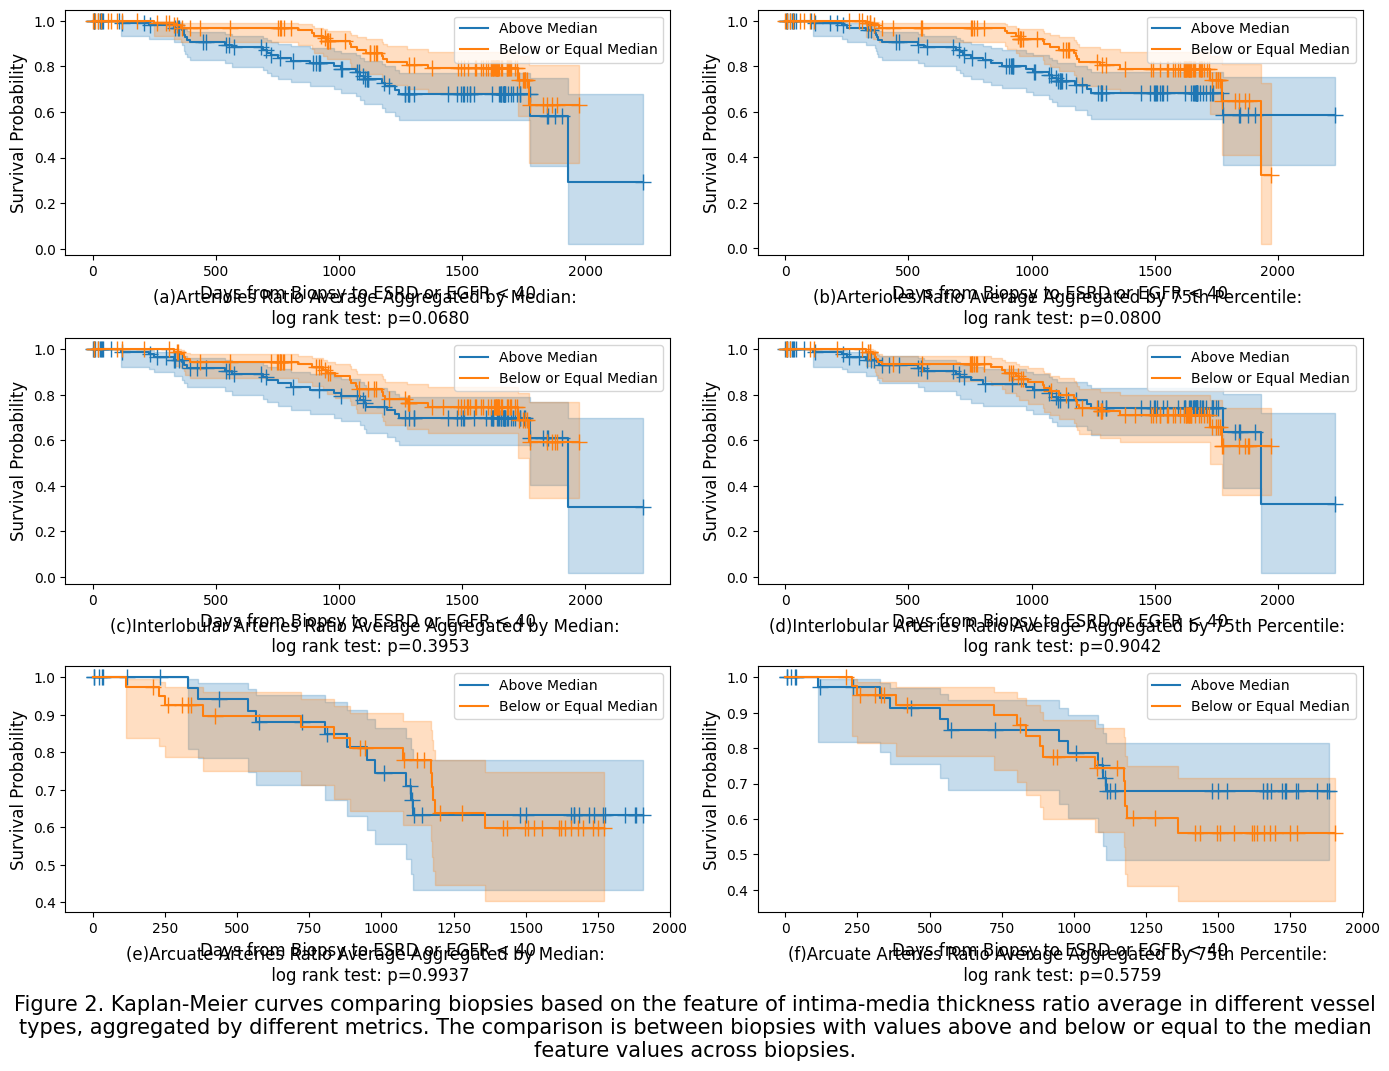

In [13]:

features = [" Ratio Average Aggregated by Median", 
            " Ratio Average Aggregated by 75th Percentile", 
        #     " Ratio Average Aggregated by Max", 
            ]

fig, axs = plt.subplots(3, len(features), figsize=(7*len(features), 10))
alphabets="abcdefghijklmnopqrstuvwxyz"
count = 0
for idx, artery_type in enumerate(ARTERY_TYPES):
    for idy, feature in enumerate(features):
        feature_name = artery_type + feature
        pat_df_selected = pat_df[pat_df[feature_name].notna()]  # Filter non-null values for the feature
        survival_analysis(pat_df_selected, feature_name, 0.5, axs[idx, idy], alphabets[count])
        count += 1
fig.text(0.5, 0, "Figure 2. Kaplan-Meier curves comparing biopsies based on the feature of intima-media thickness ratio average in different vessel types, aggregated by different metrics. The comparison is between biopsies with values above and below or equal to the median feature values across biopsies.",
        ha='center', va='top', fontsize=15, wrap=True)
plt.tight_layout()
plt.show()

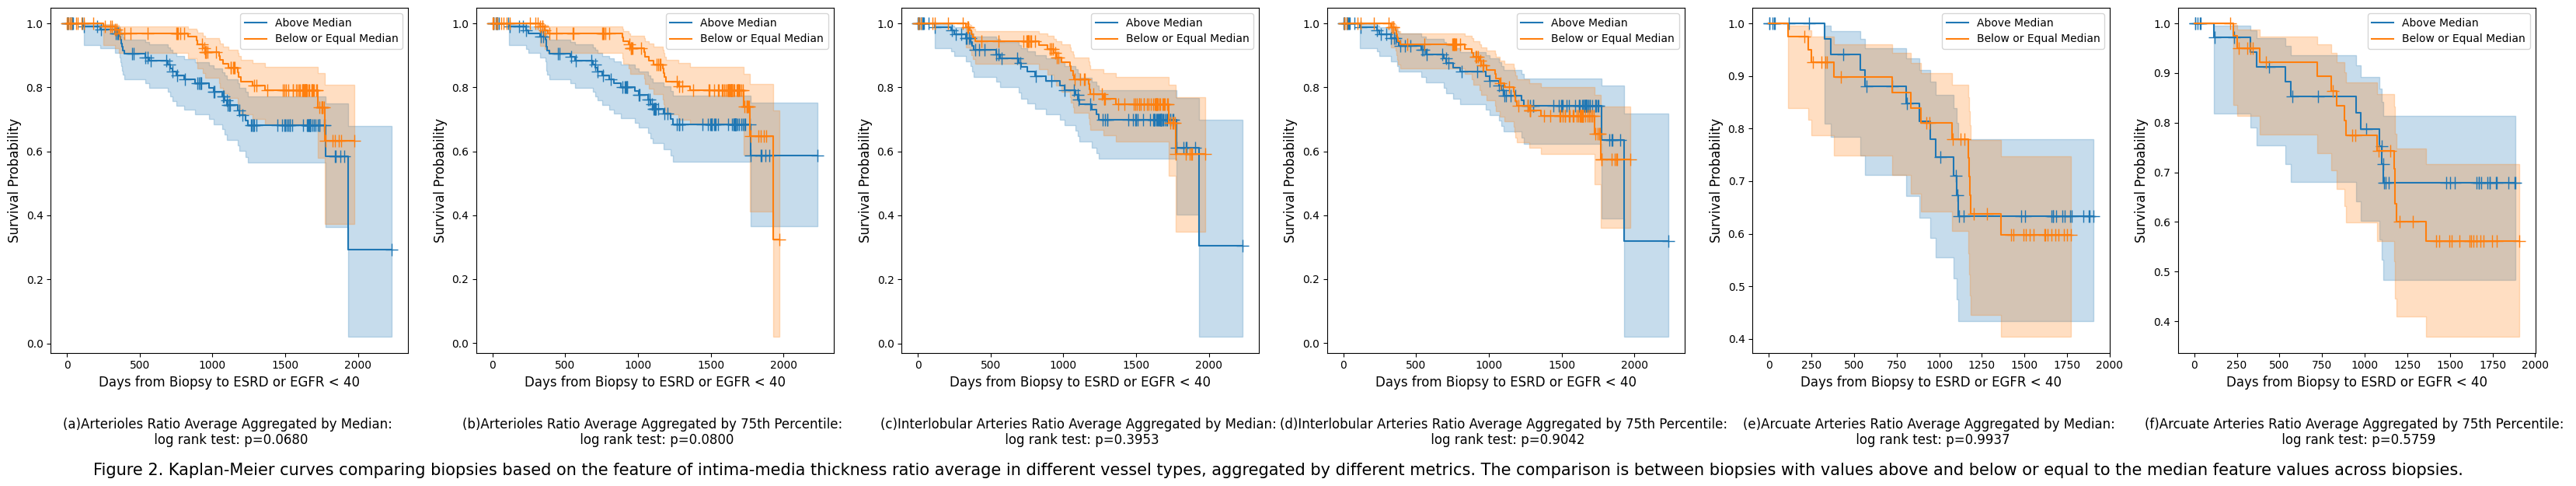

In [20]:

features = [" Ratio Average Aggregated by Median", 
            " Ratio Average Aggregated by 75th Percentile", 
        #     " Ratio Average Aggregated by Max", 
            ]

fig, axs = plt.subplots(1, len(features)*3, figsize=(5.5*len(features*3), 6))
alphabets="abcdefghijklmnopqrstuvwxyz"
count = 0
for idx, artery_type in enumerate(ARTERY_TYPES):
    for idy, feature in enumerate(features):
        feature_name = artery_type + feature
        pat_df_selected = pat_df[pat_df[feature_name].notna()]  # Filter non-null values for the feature
        survival_analysis(pat_df_selected, feature_name, 0.5, axs[count], alphabets[count])
        count += 1
fig.text(0.5, 0, "Figure 2. Kaplan-Meier curves comparing biopsies based on the feature of intima-media thickness ratio average in different vessel types, aggregated by different metrics. The comparison is between biopsies with values above and below or equal to the median feature values across biopsies.",
        ha='center', va='top', fontsize=15, wrap=True)
plt.tight_layout()
plt.show()

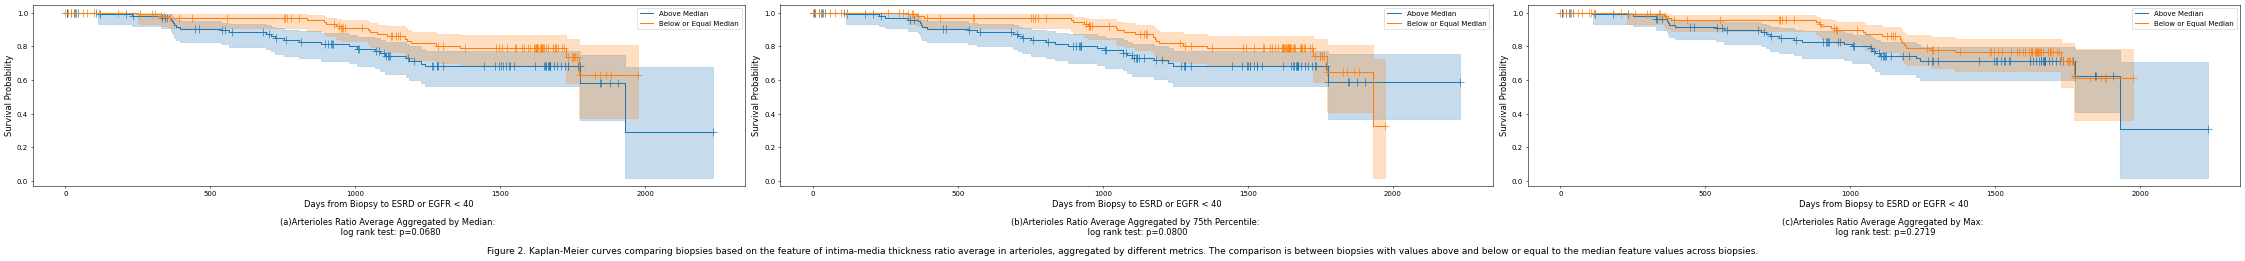

In [15]:

features = ["Arterioles Ratio Average Aggregated by Median", 
            "Arterioles Ratio Average Aggregated by 75th Percentile", 
            "Arterioles Ratio Average Aggregated by Max", 
            ]

fig, axs = plt.subplots(1, len(features), figsize=(15*len(features), 5), dpi=50)
alphabets="abcdefghijklmnopqrstuvwxyz"
count = 0
for idy, feature in enumerate(features):
    feature_name = feature
    pat_df_selected = pat_df[pat_df[feature_name].notna()]  # Filter non-null values for the feature
    survival_analysis(pat_df_selected, feature_name, 0.5, axs[idy], alphabets[count])
    count += 1
fig.text(0.5, 0, "Figure 2. Kaplan-Meier curves comparing biopsies based on the feature of intima-media thickness ratio average in arterioles, aggregated by different metrics. The comparison is between biopsies with values above and below or equal to the median feature values across biopsies.",
        ha='center', va='top', fontsize=13, wrap=True)
plt.tight_layout()
plt.show()

In [16]:
# survival_analysis_artery_type("Arterioles", percentiles = [0.5, 0.75, 0.85, 0.95])

In [17]:
# survival_analysis_artery_type("Interlobular Arteries", percentiles = [0.25, 0.75, 0.85, 0.95])

In [18]:
# survival_analysis_artery_type("Arcuate Arteries", [0.25, 0.75, 0.85, 0.95])